In [1]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import os
import sys

sys.path.append("../../../")
from src.athena import Athena
from src.utils import create_session

## Global

In [17]:
boto3_session = create_session(
    profile_name="dev",
    role_arn="arn:aws:iam::722696965592:role/athena-full-access-role",
)

wait = True
ctas_approach = False
storage_format = "PARQUET"
write_compression = "SNAPPY"

database = "fresh_segments"
tables = ["interest_map", "interest_metrics"]

athena = Athena(boto3_session=boto3_session, s3_output=os.getenv("ATHENA_S3_OUTPUT"))
athena

Athena(boto3_session=Session(region_name='us-east-1'), s3_output=s3://sql-case-studies/query_results)

## Problem Statement

Fresh Segments is a digital marketing agency specializing in analyzing trends in online ad click behavior for businesses with targeted customer bases. The agency receives customer lists from clients and aggregates interest metrics to create a comprehensive dataset for further analysis.

The main output includes detailed composition and rankings of various interests, highlighting the proportion of customers who engaged with online assets related to each interest on a monthly basis.

The goal of this case study is to analyze these aggregated metrics for a sample client to provide high-level insights into their customer base and associated interests.

## Entity Relationship Diagram

<center>
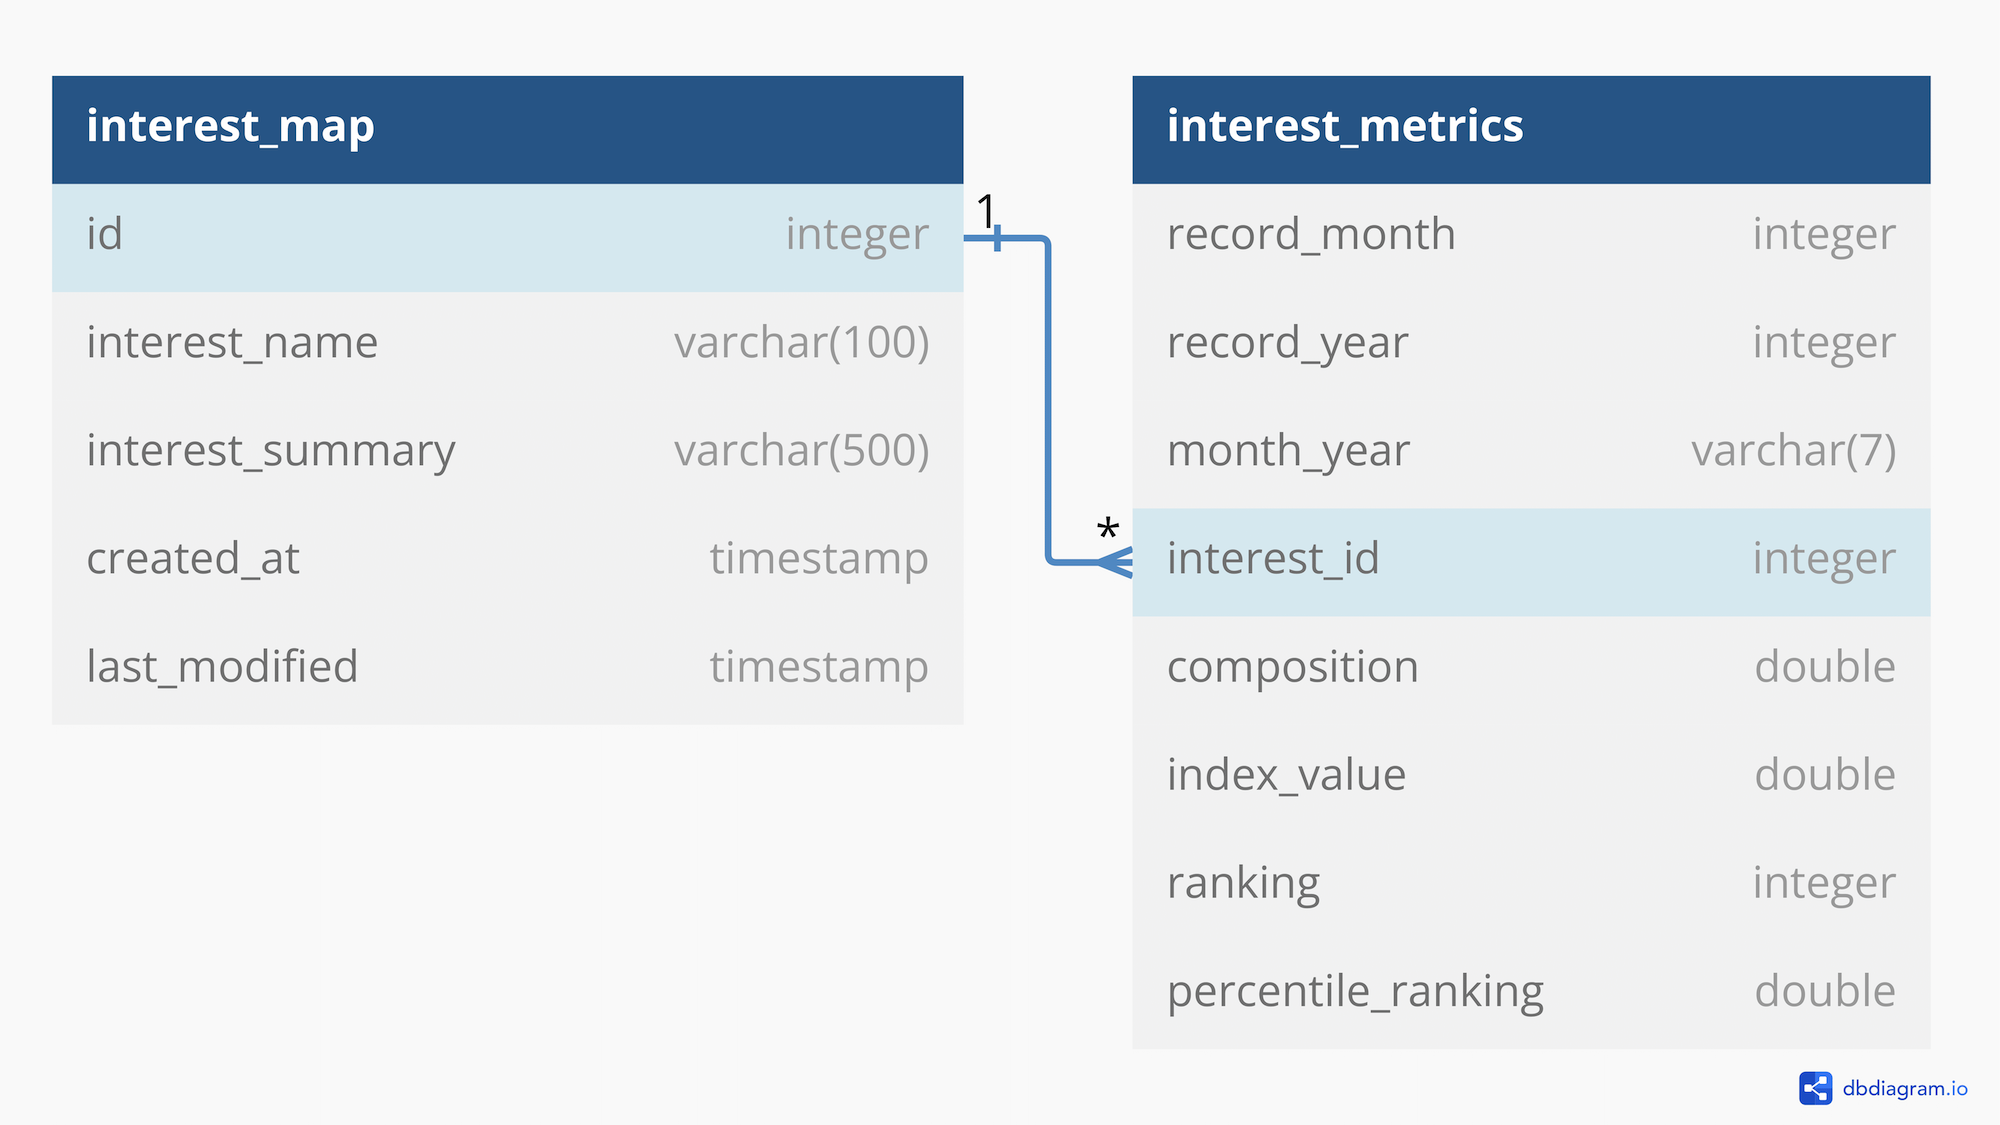
</center>

## Tables

In [3]:
for table in tables:
    athena.query(
        database=database,
        query=f""" 
                SELECT
                    *
                FROM
                    {database}.{table} TABLESAMPLE BERNOULLI(30);
              """,
        ctas_approach=ctas_approach,
    )

,id,interest_name,interest_summary,created_at,last_modified
0,3,Car Enthusiasts,Readers of automotive news and car reviews.,2016-05-26 14:57:59,2018-05-23 11:30:12
1,8,Business News Readers,Readers of online business news content.,2016-05-26 14:57:59,2018-05-23 11:30:12
2,15,NBA Fans,People reading articles and websites about bas...,2016-05-26 14:57:59,2018-05-23 11:30:13
3,17,MLB Fans,People reading articles and websites about bas...,2016-05-26 14:57:59,2018-05-23 11:30:13
4,18,Nascar Fans,People reading articles and websites about nas...,2016-05-26 14:57:59,2018-05-23 11:30:13
...,...,...,...,...,...
370,49972,Horseback Riding Enthusiasts,People reading horseback riding news and resou...,2019-04-15 18:00:00,2019-04-24 17:40:04
371,49974,Agricultural and Food Issues Researchers,People researching organizations for food and ...,2019-04-15 18:00:00,2019-04-24 17:40:04
372,49976,Agriculture and Climate Advocates,People supporting organizations for agricultur...,2019-04-15 18:00:00,2019-04-24 17:40:04
373,49979,Cape Cod News Readers,People interested in reading about local news ...,2019-04-15 18:00:00,2019-04-18 09:00:05


,record_month,record_year,month_year,interest_id,composition,index_value,ranking,percentile_ranking
0,7,2018,07-2018,6344,10.32,5.10,4,99.45
1,7,2018,07-2018,6111,10.71,4.83,8,98.90
2,7,2018,07-2018,19422,10.11,4.81,10,98.63
3,7,2018,07-2018,4895,9.47,4.67,12,98.35
4,7,2018,07-2018,6217,10.80,4.62,13,98.22
...,...,...,...,...,...,...,...,...
4255,<NA>,<NA>,<NA>,<NA>,1.98,0.80,1174,1.68
4256,<NA>,<NA>,<NA>,<NA>,1.56,0.78,1179,1.26
4257,<NA>,<NA>,<NA>,<NA>,2.05,0.76,1185,0.75
4258,<NA>,<NA>,<NA>,<NA>,1.62,0.68,1191,0.25


### Duplicate Check

Group by all columns and count the occurrences, while excluding rows with NULL values to simplify the grouping process.

#### Interest Metrics

In [7]:
query = """ 
WITH grouped_counts AS (
  SELECT
    record_month,
    record_year,
    month_year,
    interest_id,
    composition,
    index_value,
    ranking,
    percentile_ranking,
    COUNT(*) AS freq
  FROM
    fresh_segments.interest_metrics
  WHERE
    record_month IS NOT NULL
    AND record_year IS NOT NULL
    AND month_year IS NOT NULL
    AND interest_id IS NOT NULL
  GROUP BY
    record_month,
    record_year,
    month_year,
    interest_id,
    composition,
    index_value,
    ranking,
    percentile_ranking
)
SELECT
  *
FROM
  grouped_counts
WHERE
  freq > 1
ORDER BY
  freq DESC;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,record_month,record_year,month_year,interest_id,composition,index_value,ranking,percentile_ranking,freq


No duplicate are identified in the table.

### NULL Check

Number of NULL values in each column.

In [4]:
query = """ 
SELECT
    SUM(CASE WHEN record_month IS NULL THEN 1 ELSE 0 END) AS record_month_null,
    SUM(CASE WHEN record_year IS NULL THEN 1 ELSE 0 END) AS record_year_null,
    SUM(CASE WHEN month_year IS NULL THEN 1 ELSE 0 END) AS month_year_null,
    SUM(CASE WHEN interest_id IS NULL THEN 1 ELSE 0 END) AS interest_id_null,
    SUM(CASE WHEN composition IS NULL THEN 1 ELSE 0 END) AS composition_null,
    SUM(CASE WHEN index_value IS NULL THEN 1 ELSE 0 END) AS index_value_null,
    SUM(CASE WHEN ranking IS NULL THEN 1 ELSE 0 END) AS ranking_null,
    SUM(CASE WHEN percentile_ranking IS NULL THEN 1 ELSE 0 END) AS percentile_ranking_null
FROM
    fresh_segments.interest_metrics;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,record_month_null,record_year_null,month_year_null,interest_id_null,composition_null,index_value_null,ranking_null,percentile_ranking_null
0,1194,1194,1194,1193,0,0,0,0


## EDA & Data Preprocessing

## Q1 & Q3

There are two preprocessing steps that can be helpful:

1. Update the `fresh_segments.interest_metrics` table by modifying the `month_year` column to be a date data type with the start of the month as the day.

2. Handeling the null values in the `fresh_segments.interest_metrics` table. 

First, check the amount of records with non-missing interest ID but missing `month_year` value:

In [41]:
query = """ 
SELECT 
    interest_id
FROM
    fresh_segments.interest_metrics
WHERE
    1 = 1
    AND month_year IS NULL
    AND interest_id IS NOT NULL;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,interest_id
0,21246


For all records that have both missing `month_year` and `interest_id` values in the `fresh_segments.interest_metrics` table, we unfortunately cannot make any good business interpretations on their interest metrics since we do not know what interest they are associated with.

For the single record where the `interest_id` is known but the `month_year` is missing, we can check if there are any other records with the same `interest_id` value and a non-missing `month_year` value.

In [42]:
query = """ 
SELECT
    *
FROM
    fresh_segments.interest_metrics
WHERE
    interest_id = 21246;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,record_month,record_year,month_year,interest_id,composition,index_value,ranking,percentile_ranking
0,7,2018,07-2018,21246,2.26,0.65,722,0.96
1,8,2018,08-2018,21246,2.13,0.59,765,0.26
2,9,2018,09-2018,21246,2.06,0.61,774,0.77
3,10,2018,10-2018,21246,1.74,0.58,855,0.23
4,11,2018,11-2018,21246,2.25,0.78,908,2.16
5,12,2018,12-2018,21246,1.97,0.70,983,1.21
6,1,2019,01-2019,21246,2.05,0.76,954,1.95
7,2,2019,02-2019,21246,1.84,0.68,1109,1.07
8,3,2019,03-2019,21246,1.75,0.67,1123,1.14
9,4,2019,04-2019,21246,1.58,0.63,1092,0.64


In this case, the options are:

* Impute the missing `month_year` value with the `month_year` value of the lateset record with the same `interest_id` value

* Impute the missing `month_year` value with the `created_at` value from the `fresh_segments.interest_map` table

* Drop the record

The first two options run the risk of introducing bias into the data, but dropping the record may result in a loss of valuable information. Given that there is only one record with a missing `month_year` value, we can argue that the risk of losing valuable information is low relative to the risk of introducing bias into the data by imputing date information.

In [43]:
# New ctas table with modified column and dropping all records with missing date information
query = """ 
SELECT
    record_month,
    record_year,
    CASE WHEN month_year IS NULL THEN NULL ELSE DATE_PARSE(CONCAT_WS('-', '01', month_year), '%d-%m-%Y') END AS month_year,
    interest_id,
    composition,
    index_value,
    ranking,
    percentile_ranking
FROM
    fresh_segments.interest_metrics
WHERE
    month_year IS NOT NULL;
"""

athena.create_ctas_table(
    database=database,
    query=query,
    ctas_table="interest_metrics_modified",
    s3_output="s3://sql-case-studies/fresh_segments/interest_metrics/",
    storage_format=storage_format,
    write_compression=write_compression,
    wait=wait,
)

# Drop old table
athena.drop_table(database=database, table="interest_metrics")

{'ctas_database': 'fresh_segments',
 'ctas_table': 'interest_metrics_modified',
 'ctas_query_metadata': _QueryMetadata(execution_id='d09dce36-f449-410d-972e-f0001d797f3c', dtype={'rows': 'Int64'}, parse_timestamps=[], parse_dates=[], parse_geometry=[], converters={}, binaries=[], output_location='s3://sql-case-studies/fresh_segments/interest_metrics/tables/d09dce36-f449-410d-972e-f0001d797f3c', manifest_location='s3://sql-case-studies/fresh_segments/interest_metrics/tables/d09dce36-f449-410d-972e-f0001d797f3c-manifest.csv', raw_payload={'QueryExecutionId': 'd09dce36-f449-410d-972e-f0001d797f3c', 'Query': 'CREATE TABLE "fresh_segments"."interest_metrics_modified"\nWITH(\n    external_location = \'s3://sql-case-studies/fresh_segments/interest_metrics/interest_metrics_modified\',\n    write_compression = \'SNAPPY\',\n    format = \'PARQUET\')\nAS  \nSELECT\n    record_month,\n    record_year,\n    CASE WHEN month_year IS NULL THEN NULL ELSE DATE_PARSE(CONCAT_WS(\'-\', \'01\', month_year),

Query executed successfully


In [44]:
# New ctas table with original name
query = """ 
SELECT
    *
FROM
    fresh_segments.interest_metrics_modified;
"""

athena.create_ctas_table(
    database=database,
    query=query,
    ctas_table="interest_metrics",
    s3_output="s3://sql-case-studies/fresh_segments/interest_metrics/",
    storage_format=storage_format,
    write_compression=write_compression,
    wait=wait,
)

# Drop temporary ctas table
athena.drop_table(database=database, table="interest_metrics_modified")

{'ctas_database': 'fresh_segments',
 'ctas_table': 'interest_metrics',
 'ctas_query_metadata': _QueryMetadata(execution_id='cafcac3b-bbfb-42a7-a999-65ca51d5a1be', dtype={'rows': 'Int64'}, parse_timestamps=[], parse_dates=[], parse_geometry=[], converters={}, binaries=[], output_location='s3://sql-case-studies/fresh_segments/interest_metrics/tables/cafcac3b-bbfb-42a7-a999-65ca51d5a1be', manifest_location='s3://sql-case-studies/fresh_segments/interest_metrics/tables/cafcac3b-bbfb-42a7-a999-65ca51d5a1be-manifest.csv', raw_payload={'QueryExecutionId': 'cafcac3b-bbfb-42a7-a999-65ca51d5a1be', 'Query': 'CREATE TABLE "fresh_segments"."interest_metrics"\nWITH(\n    external_location = \'s3://sql-case-studies/fresh_segments/interest_metrics/interest_metrics\',\n    write_compression = \'SNAPPY\',\n    format = \'PARQUET\')\nAS  \nSELECT\n    *\nFROM\n    fresh_segments.interest_metrics_modified', 'StatementType': 'DDL', 'ResultConfiguration': {'OutputLocation': 's3://sql-case-studies/fresh_segme

Query executed successfully


In [45]:
query = """ 
SELECT
    * 
FROM
    fresh_segments.interest_metrics TABLESAMPLE BERNOULLI(30);
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,record_month,record_year,month_year,interest_id,composition,index_value,ranking,percentile_ranking
0,7,2018,2018-07-01,6106,9.93,5.31,2,99.73
1,7,2018,2018-07-01,6344,10.32,5.10,4,99.45
2,7,2018,2018-07-01,79,11.21,4.97,7,99.04
3,7,2018,2018-07-01,19422,10.11,4.81,10,98.63
4,7,2018,2018-07-01,4895,9.47,4.67,12,98.35
...,...,...,...,...,...,...,...,...
3963,8,2019,2019-08-01,13428,2.08,0.94,1128,1.83
3964,8,2019,2019-08-01,33957,1.74,0.93,1130,1.65
3965,8,2019,2019-08-01,16198,1.82,0.90,1139,0.87
3966,8,2019,2019-08-01,19591,1.81,0.88,1141,0.70


In [47]:
query = """ 
SELECT
    COUNT(*) AS record_count
FROM
    fresh_segments.interest_metrics;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,record_count
0,13079


## Q2

What is count of records in the `fresh_segments.interest_metrics` table for each `month_year` value sorted in chronological order (earliest to latest) with the null values appearing first?

In [48]:
query = """ 
SELECT
    month_year,
    COUNT(DISTINCT interest_id) AS unique_interest_count
FROM
    fresh_segments.interest_metrics
GROUP BY
    month_year
ORDER BY
    month_year ASC NULLS FIRST;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,month_year,unique_interest_count
0,2018-07-01,729
1,2018-08-01,767
2,2018-09-01,780
3,2018-10-01,857
4,2018-11-01,928
5,2018-12-01,995
6,2019-01-01,973
7,2019-02-01,1121
8,2019-03-01,1136
9,2019-04-01,1099


## Q4

How many `interest_id` values exist in the `fresh_segments.interest_metrics` table but not in the `fresh_segments.interest_map` table? What about the other way around?

Let `A` be the set of `interest_id` values in the `fresh_segments.interest_metrics` table and `B` be the set of `interest_id` values in the `fresh_segments.interest_map` table.

### A \ B & B \ A

We can use a full outer join, which returns **all rows from both tables** regardless of whether there is a match or not:

In [55]:
query = """ 
SELECT
    COUNT(DISTINCT met.interest_id) AS metrics_id_unique_count,
    COUNT(DISTINCT map.id) AS map_id_unique_count,
    SUM(CASE WHEN met.interest_id IS NULL AND map.id IS NOT NULL THEN 1 ELSE 0 END) AS in_map_not_in_metrics_count,
    SUM(CASE WHEN met.interest_id IS NOT NULL AND map.id IS NULL THEN 1 ELSE 0 END) AS in_metrics_not_in_map_count
FROM
    fresh_segments.interest_metrics AS met 
        FULL JOIN fresh_segments.interest_map AS map ON met.interest_id = map.id;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,metrics_id_unique_count,map_id_unique_count,in_map_not_in_metrics_count,in_metrics_not_in_map_count
0,1202,1209,7,0


## Q5

Summarise the `id` values in the `fresh_segments.interest_map` by its total record count in this table.

In [56]:
query = """ 
SELECT
    COUNT(id) AS raw_count
FROM
    fresh_segments.interest_map;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,raw_count
0,1209


## Q6

What sort of table join would be most appropriate to combine the `fresh_segments.interest_metrics` and `fresh_segments.interest_map` tables?

Because there are the asymmetric difference between the `interest_id` values in the `fresh_segments.interest_metrics` and the `id` values in `fresh_segments.interest_map` tables is the null set, it would be most appropriate to left join the `interest_map` table onto the `interest_metrics` table.

In [65]:
query = """ 
SELECT
    met.interest_id,
    met.record_month,
    met.record_year,
    met.month_year,
    met.composition,
    met.index_value,
    met.ranking,
    met.percentile_ranking,
    map.interest_name,
    map.interest_summary,
    map.created_at,
    map.last_modified
FROM
    fresh_segments.interest_metrics AS met 
        LEFT JOIN fresh_segments.interest_map AS map ON met.interest_id = map.id
WHERE
    met.interest_id = 21246;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,interest_id,record_month,record_year,month_year,composition,index_value,ranking,percentile_ranking,interest_name,interest_summary,created_at,last_modified
0,21246,7,2018,2018-07-01,2.26,0.65,722,0.96,Readers of El Salvadoran Content,People reading news from El Salvadoran media s...,2018-06-11 17:50:04,2018-06-11 17:50:04
1,21246,8,2018,2018-08-01,2.13,0.59,765,0.26,Readers of El Salvadoran Content,People reading news from El Salvadoran media s...,2018-06-11 17:50:04,2018-06-11 17:50:04
2,21246,9,2018,2018-09-01,2.06,0.61,774,0.77,Readers of El Salvadoran Content,People reading news from El Salvadoran media s...,2018-06-11 17:50:04,2018-06-11 17:50:04
3,21246,10,2018,2018-10-01,1.74,0.58,855,0.23,Readers of El Salvadoran Content,People reading news from El Salvadoran media s...,2018-06-11 17:50:04,2018-06-11 17:50:04
4,21246,11,2018,2018-11-01,2.25,0.78,908,2.16,Readers of El Salvadoran Content,People reading news from El Salvadoran media s...,2018-06-11 17:50:04,2018-06-11 17:50:04
5,21246,12,2018,2018-12-01,1.97,0.70,983,1.21,Readers of El Salvadoran Content,People reading news from El Salvadoran media s...,2018-06-11 17:50:04,2018-06-11 17:50:04
6,21246,1,2019,2019-01-01,2.05,0.76,954,1.95,Readers of El Salvadoran Content,People reading news from El Salvadoran media s...,2018-06-11 17:50:04,2018-06-11 17:50:04
7,21246,2,2019,2019-02-01,1.84,0.68,1109,1.07,Readers of El Salvadoran Content,People reading news from El Salvadoran media s...,2018-06-11 17:50:04,2018-06-11 17:50:04
8,21246,3,2019,2019-03-01,1.75,0.67,1123,1.14,Readers of El Salvadoran Content,People reading news from El Salvadoran media s...,2018-06-11 17:50:04,2018-06-11 17:50:04
9,21246,4,2019,2019-04-01,1.58,0.63,1092,0.64,Readers of El Salvadoran Content,People reading news from El Salvadoran media s...,2018-06-11 17:50:04,2018-06-11 17:50:04


## Q7

Are there any records in the joined table where the `month_year` value is before the `created_at` value from the `fresh_segments.interest_map` table? Are these values are valid and why?

In [67]:
query = """ 
SELECT
    met.interest_id,
    met.record_month,
    met.record_year,
    met.month_year,
    met.composition,
    met.index_value,
    met.ranking,
    met.percentile_ranking,
    map.interest_name,
    map.interest_summary,
    map.created_at,
    map.last_modified
FROM
    fresh_segments.interest_metrics AS met 
        LEFT JOIN fresh_segments.interest_map AS map ON met.interest_id = map.id
WHERE
    met.month_year < map.created_at;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,interest_id,record_month,record_year,month_year,composition,index_value,ranking,percentile_ranking,interest_name,interest_summary,created_at,last_modified
0,32704,7,2018,2018-07-01,8.04,2.27,225,69.14,Major Airline Customers,People visiting sites for major airline brands...,2018-07-06 14:35:04,2018-07-06 14:35:04
1,33191,7,2018,2018-07-01,3.99,2.11,283,61.18,Online Shoppers,People who spend money online,2018-07-17 10:40:03,2018-07-17 10:46:58
2,32703,7,2018,2018-07-01,5.53,1.80,375,48.56,School Supply Shoppers,Consumers shopping for classroom supplies for ...,2018-07-06 14:35:04,2018-07-06 14:35:04
3,32701,7,2018,2018-07-01,4.23,1.41,483,33.74,Womens Equality Advocates,People visiting sites advocating for womens eq...,2018-07-06 14:35:03,2018-07-06 14:35:03
4,32705,7,2018,2018-07-01,4.38,1.34,505,30.73,Certified Events Professionals,Professionals reading industry news and resear...,2018-07-06 14:35:04,2018-07-06 14:35:04
...,...,...,...,...,...,...,...,...,...,...,...,...
183,49972,4,2019,2019-04-01,2.11,1.15,722,34.30,Horseback Riding Enthusiasts,People reading horseback riding news and resou...,2019-04-15 18:00:00,2019-04-24 17:40:04
184,49502,4,2019,2019-04-01,1.87,1.12,768,30.12,Veterinarians,Veterinarians,2019-04-08 18:00:05,2019-07-09 13:57:13
185,49974,4,2019,2019-04-01,2.00,1.10,799,27.30,Agricultural and Food Issues Researchers,People researching organizations for food and ...,2019-04-15 18:00:00,2019-04-24 17:40:04
186,49973,4,2019,2019-04-01,1.66,1.03,910,17.20,Farm Finance Researchers,People researching financial institutions spec...,2019-04-15 18:00:00,2019-04-24 17:40:04


Some `month_year` values are before the `created_at` values in the `fresh_segments.interest_map` table because the former is less granular than the latter. The `month_year` value is the month and year of the interest metrics, while the `created_at` value is the timestamp of when the interest was created. We also preprocessed the `month_year` to be the first day of the month, so it is expected that some `month_year` values will be before the `created_at` values.

We can verify that there are no records where the difference between the `month_year` and `created_at` values greater than 1 month, which would be a sign of data quality issues.

In [90]:
query = """ 
SELECT
    met.interest_id,
    met.record_month,
    met.record_year,
    met.month_year,
    met.composition,
    met.index_value,
    met.ranking,
    met.percentile_ranking,
    map.interest_name,
    map.interest_summary,
    map.created_at,
    map.last_modified
FROM
    fresh_segments.interest_metrics AS met 
        LEFT JOIN fresh_segments.interest_map AS map ON met.interest_id = map.id
WHERE
    met.month_year < map.created_at
    AND DATE_DIFF('DAY', met.month_year, map.created_at) > 30;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,interest_id,record_month,record_year,month_year,composition,index_value,ranking,percentile_ranking,interest_name,interest_summary,created_at,last_modified


Another way to verfiy is to use `DATE_TRUNC` function to truncate the `created_at` values to the month level and compare the `month_year` values with the truncated `created_at` values.

In [91]:
query = """ 
SELECT
    met.interest_id,
    met.record_month,
    met.record_year,
    met.month_year,
    met.composition,
    met.index_value,
    met.ranking,
    met.percentile_ranking,
    map.interest_name,
    map.interest_summary,
    map.created_at,
    map.last_modified
FROM
    fresh_segments.interest_metrics AS met 
        LEFT JOIN fresh_segments.interest_map AS map ON met.interest_id = map.id
WHERE
    met.month_year < DATE_TRUNC('MONTH', map.created_at);
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,interest_id,record_month,record_year,month_year,composition,index_value,ranking,percentile_ranking,interest_name,interest_summary,created_at,last_modified
